In [7]:
import sys
import os

# This adds the parent directory (root) to the python path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Loading the Training Dataset

In [8]:
# load data
import pandas as pd

df = pd.read_csv("../data/train.csv")
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


## Overview of the Dataset

In [9]:
# overview
import numpy as np

print(f"total: {df.shape[0]}")
print(f"unique categorical values: {df["is_duplicate"].unique()}")
print(f"class distribution: {df["is_duplicate"].value_counts()}")
print(f"mean: {df["is_duplicate"].mean():.3}")
print(f"standard deviation: {df["is_duplicate"].std():.3}")
print(f"missing: question1={df["question1"].isnull().sum()}, question2={df["question2"].isnull().sum()}")
print(f"duplicates: {df.duplicated().sum()}")
qid = pd.Series(df["qid1"].tolist() + df["qid2"].tolist())
print(f"unique questions: {np.unique(qid).shape[0]}")
x = qid.value_counts() > 1
print(f"repeated questions: {x[x].shape[0]}")
print("data types: ")
print(df.dtypes)

total: 404290
unique categorical values: [0 1]
class distribution: is_duplicate
0    255027
1    149263
Name: count, dtype: int64
mean: 0.369
standard deviation: 0.483
missing: question1=1, question2=2
duplicates: 0
unique questions: 537933
repeated questions: 111780
data types: 
id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object


### Dropping missing values

In [10]:
# can drop missing values since only 3
df.dropna(inplace=True)

### Class Distribution

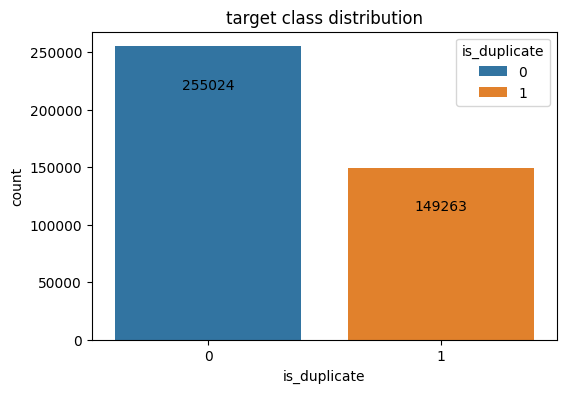

In [11]:
# plot to visualize class distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
ax = sns.countplot(data=df, x="is_duplicate", hue="is_duplicate", palette={0: "tab:blue", 1: "tab:orange"})
ax.bar_label(ax.containers[0], padding=-33)
ax.bar_label(ax.containers[1], padding=-33)
plt.title("target class distribution")
plt.xlabel("is_duplicate")
plt.ylabel("count")
plt.show()

## Removing html and special characters

In [ ]:
import re
from bs4 import BeautifulSoup
import inflect
from scripts.utils.loader import load_contractions

p = inflect.engine()
contractions = load_contractions()

def preprocess(text):
	text = text.lower()
	# remove html tags
	text = BeautifulSoup(str(text), "html.parser").get_text()
	# expand contractions
	for contraction, expansion in contractions.items():
		text = text.replace(contraction, expansion)
	# numeric to text
	text = re.sub(r"(\d+)", lambda x: p.number_to_words(x.group(0)), text)
	text = re.sub(r"[^a-z\s]", " ", text)
	return " ".join(text.split())

df["question1"] = df["question1"].apply(preprocess)
df["question2"] = df["question2"].apply(preprocess)

## Feature Engineering

In [13]:
# count of words
df["q1_len"] = df["question1"].apply(lambda x: len(str(x).split()))
df["q2_len"] = df["question2"].apply(lambda x: len(str(x).split()))

# common words
df["common_words"] = df.apply(lambda x: len(set(str(x["question1"]).lower().split()) & set(str(x["question2"]).lower().split())), axis=1)

# unique words
df["unique_words"] = df.apply(lambda x: len(set(str(x["question1"]).lower().split()) | set(str(x["question2"]).lower().split())), axis=1)

# word share
df["word_share"] = ((df["common_words"] / df["unique_words"]) * 100).round(2)

# question frequency in the whole dataset
qid_counts = qid.value_counts()
df["q1_freq"] = df["qid1"].map(qid_counts)
df["q2_freq"] = df["qid2"].map(qid_counts)

# sum of frequencies: how popular is the pair?
df["freq_sum"] = df["q1_freq"] + df["q2_freq"]

# difference of frequencies: is one question more popular than the other
df["freq_diff"] = abs(df["q1_freq"] - df["q2_freq"])

### Analysis of Features

In [14]:
features = df.drop(columns=["id", "qid1", "qid2", "question1", "question2"]).columns

stats_list = []

for col in features:
    data = df[col]

    # calculate inter quartile range
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1

    stats_list.append({
        "feature": col,
        "mean": data.mean(),
        "median": data.median(),
        "mode": data.mode()[0],
        "min": data.min(),
        "max": data.max(),
        "range": data.max() - data.min(),
        "variance": data.var(),
        "std Dev": data.std(),
        "iqr": iqr,
        "skewness": data.skew(),
        "kurtosis": data.kurtosis()
    })

# download the statistical data
stats_df = pd.DataFrame(stats_list)
stats_df.to_csv("../data/feature_statistics.csv", index=False)
stats_df.head(11)

,feature,mean,median,mode,min,max,range,variance,std Dev,iqr,skewness,kurtosis
0,is_duplicate,0.369201,0.00,0.0,0.0,1.0,1.0,0.232892,0.482589,1.00,0.542076,-1.706162
1,q1_len,11.285542,10.00,8.0,0.0,128.0,128.0,32.930370,5.738499,5.00,1.933874,6.861608
2,q2_len,11.536381,10.00,8.0,0.0,247.0,247.0,44.006947,6.633773,7.00,3.993831,70.910129
3,common_words,5.127580,5.00,4.0,0.0,40.0,40.0,10.465355,3.235020,4.00,1.307685,3.492473
4,unique_words,16.417780,15.00,12.0,0.0,144.0,144.0,62.938070,7.933352,9.00,1.552248,4.708395
5,word_share,37.154345,33.33,50.0,0.0,100.0,100.0,592.762999,24.346725,35.67,0.539833,-0.583207
6,q1_freq,3.811631,1.00,1.0,1.0,157.0,156.0,43.690090,6.609848,2.00,5.128904,50.215886
7,q2_freq,4.030983,1.00,1.0,1.0,157.0,156.0,61.709824,7.855560,2.00,6.563506,76.620446
8,freq_sum,7.842614,3.00,2.0,2.0,213.0,211.0,171.204120,13.084499,5.00,4.256707,24.851291
9,freq_diff,1.974451,1.00,0.0,0.0,156.0,156.0,35.745356,5.978742,2.00,12.138087,226.697255


### Handling outliers and skewness

In [15]:
# features with outliers or high range
uncapped_cols = ["q1_len", "q2_len", "unique_words", "word_share"]

for col in uncapped_cols:
	q_limit = df[col].quantile(0.99)
	df[col] = df[col].clip(upper=q_limit)

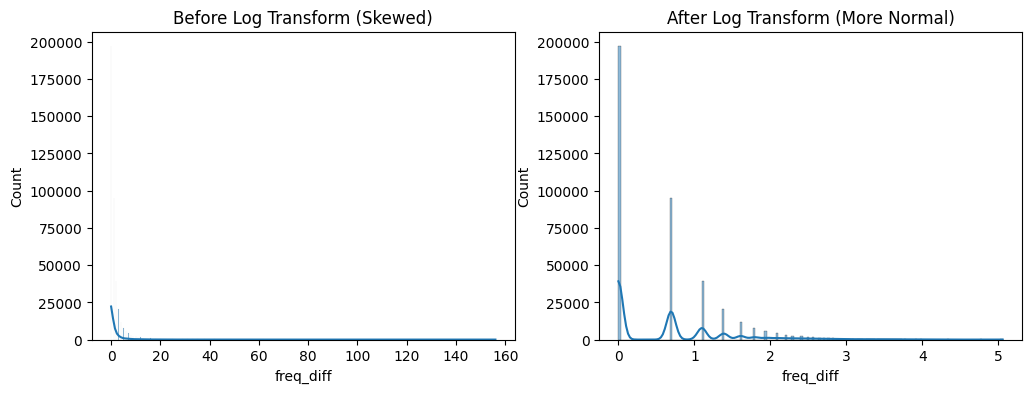

In [16]:
# features with high skewness
skewed_cols = ["q1_freq", "q2_freq", "freq_sum", "freq_diff"]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(df["freq_diff"], kde=True)
plt.title("Before Log Transform (Skewed)")

for col in skewed_cols:
    # log transformation
    df[col] = np.log1p(df[col])

plt.subplot(1, 2, 2)
sns.histplot(df["freq_diff"], kde=True)
plt.title("After Log Transform (More Normal)")
plt.show()

### word_share distribution

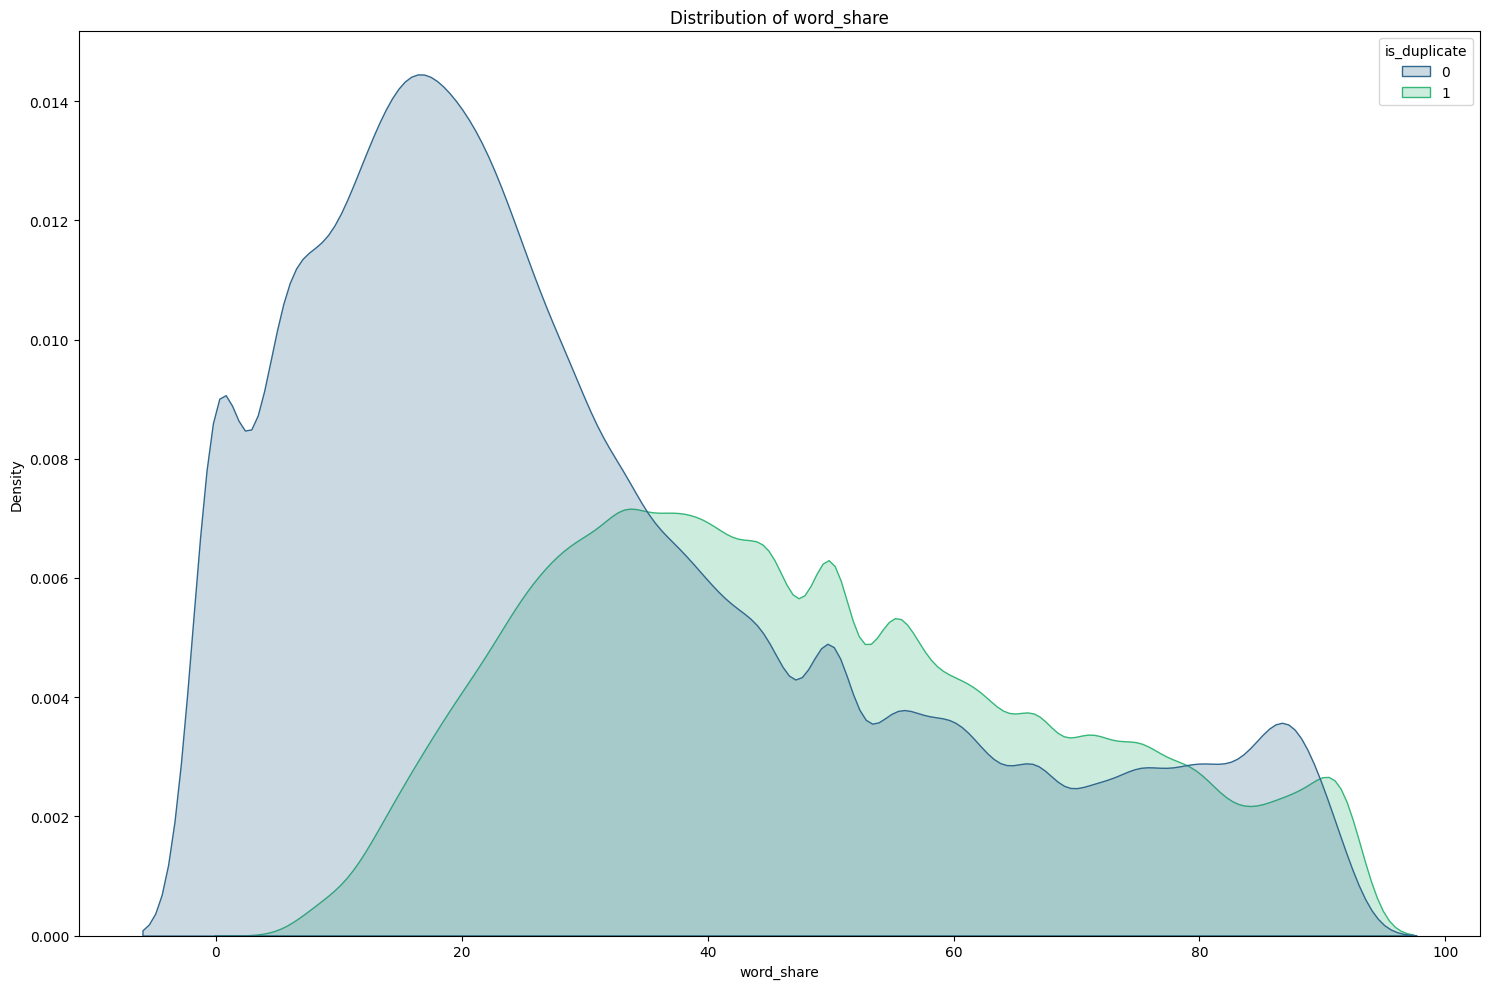

In [17]:
plt.figure(figsize=(15, 10))
sns.kdeplot(data=df, x="word_share", hue="is_duplicate", fill=True, palette="viridis")
plt.title(f"Distribution of word_share")

plt.tight_layout()
plt.show()

### Box plot of word_share vs target class

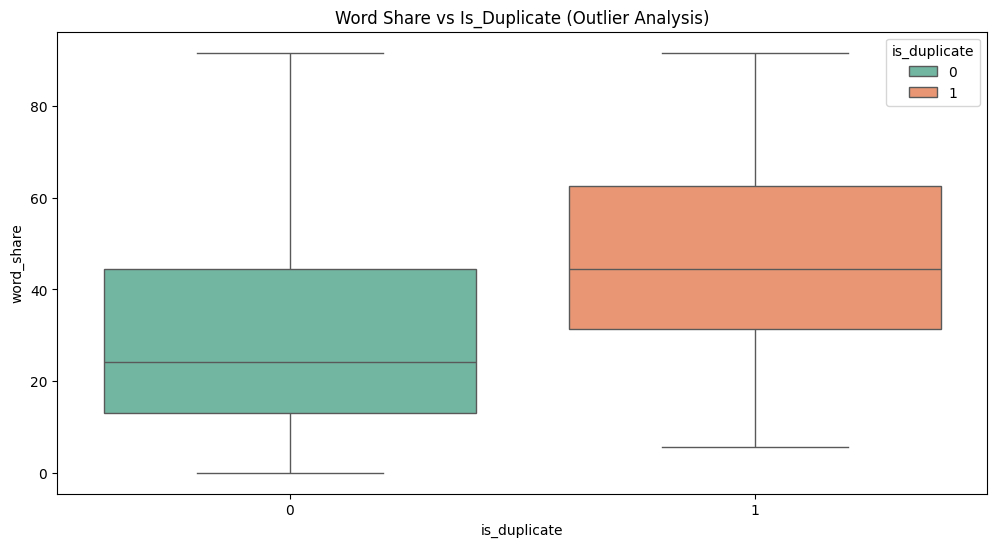

In [18]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="is_duplicate", y="word_share", palette="Set2", hue="is_duplicate")
plt.title("Word Share vs Is_Duplicate (Outlier Analysis)")
plt.show()